Combined method onset: 0.023s


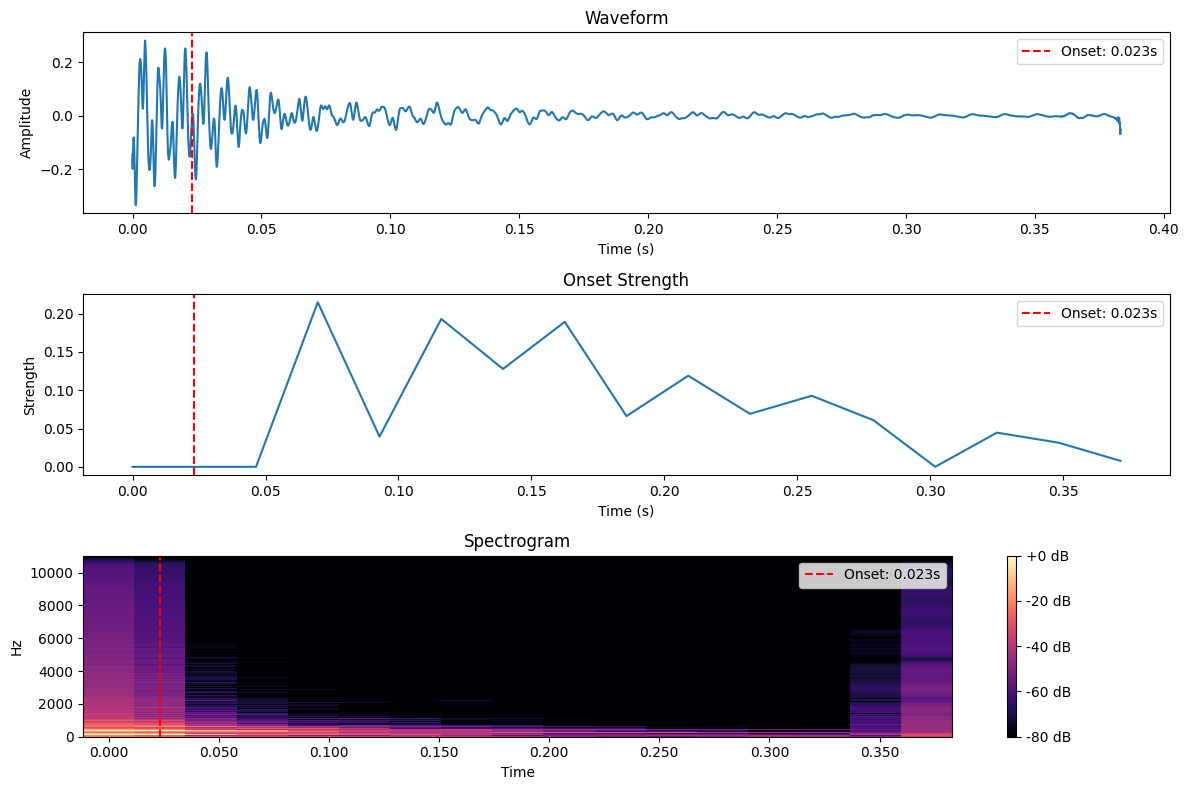

In [1]:
import librosa
import numpy as np
from typing import List, Tuple, Optional
from pathlib import Path
import matplotlib.pyplot as plt

def get_audio(path: Path) -> Tuple[np.array, float]:
    """
    Load audio file.
    Args:
        path: Path to audio file
    Returns:
        Tuple of audio signal and sample rate
    """
    audio, sr = librosa.load(path, sr=22050)
    return audio, sr

def get_onset(audio: np.array, sr: float) -> Optional[float]:
    """
    Improved onset detection specifically for mridangam percussion.
    
    Args:
        audio: Audio signal
        sr: Sample rate
    Returns:
        Onset time in seconds
    """
    # Method 1: Spectral flux
    spectral_onsets = librosa.onset.onset_detect(
        y=audio, sr=sr, units='time',
        onset_envelope=librosa.onset.onset_strength(y=audio, sr=sr),
        pre_max=3, post_max=3, pre_avg=3, post_avg=3,
        delta=0.3, wait=5
    )
    
    # Method 2: Energy-based (fix: compute RMS separately)
    rms_features = librosa.feature.rms(y=audio)[0]
    # Convert RMS to onset strength manually
    rms_diff = np.diff(rms_features, prepend=rms_features[0])
    rms_diff = np.maximum(0, rms_diff)  # Only positive changes
    
    energy_onsets = librosa.onset.onset_detect(
        onset_envelope=rms_diff,
        sr=sr, units='time',
        pre_max=3, post_max=3, pre_avg=3, post_avg=3,
        delta=0.4, wait=5
    )
    
    # Combine all detected onsets
    all_onsets = np.concatenate([spectral_onsets, energy_onsets])
    
    # Remove duplicates within 50ms window
    if len(all_onsets) > 0:
        all_onsets = np.sort(all_onsets)
        unique_onsets = [all_onsets[0]]
        for onset in all_onsets[1:]:
            if onset - unique_onsets[-1] > 0.05:  # 50ms threshold
                unique_onsets.append(onset)
        onset_times = np.array(unique_onsets)
    else:
        onset_times = all_onsets
    
    return onset_times[0] if len(onset_times) > 0 else None

def get_window(onset: float, audio: np.array, sr: float, 
                       pre_onset: float = 0.05, post_onset: float = 0.15) -> np.array:
    """
    Get audio window around onset with adaptive timing based on audio energy.
    """
    duration: float = pre_onset + post_onset
    window_samples: int = int(duration * sr)
    if onset is None:
        if len(audio) >= window_samples:
            return audio[:window_samples]
        else:
            # Pad if audio is shorter than window
            return np.pad(audio, (0, window_samples - len(audio)), mode='constant')
    
    # Calculate window boundaries
    # Put onset at 25% of window (to capture pre-attack)
    pre_onset_duration = duration * 0.25
    
    start_time = max(0, onset - pre_onset_duration)
    end_time = start_time + duration
    
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # Handle edge cases
    if end_sample > len(audio):
        # If we exceed audio length, shift window back
        end_sample = len(audio)
        start_sample = max(0, end_sample - window_samples)
    
    # Extract window
    window = audio[start_sample:end_sample]
    
    # Ensure exact duration by padding if necessary
    if len(window) < window_samples:
        pad_amount = window_samples - len(window)
        window = np.pad(window, (0, pad_amount), mode='constant')
    elif len(window) > window_samples:
        window = window[:window_samples]
    
    return window

def get_mel_spectrogram(audio: np.array, sr: float) -> np.array:
    """
    Compute mel spectrogram.
    Args:
        audio: Audio signal
        sr: Sample rate
    Returns:
        Mel spectrogram
    """
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

def visualize_onset_detection(audio: np.array, sr: float, onset: float = None):
    """
    Visualize the onset detection results.
    """
    plt.figure(figsize=(12, 8))
    
    # Plot waveform
    plt.subplot(3, 1, 1)
    times = np.linspace(0, len(audio)/sr, len(audio))
    plt.plot(times, audio)
    if onset is not None:
        plt.axvline(x=onset, color='r', linestyle='--', label=f'Onset: {onset:.3f}s')
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plot onset strength
    plt.subplot(3, 1, 2)
    onset_envelope = librosa.onset.onset_strength(y=audio, sr=sr)
    times_onset = librosa.frames_to_time(np.arange(len(onset_envelope)), sr=sr)
    plt.plot(times_onset, onset_envelope)
    if onset is not None:
        plt.axvline(x=onset, color='r', linestyle='--', label=f'Onset: {onset:.3f}s')
    plt.title('Onset Strength')
    plt.xlabel('Time (s)')
    plt.ylabel('Strength')
    plt.legend()
    
    # Plot spectrogram
    plt.subplot(3, 1, 3)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sr)
    if onset is not None:
        plt.axvline(x=onset, color='r', linestyle='--', label=f'Onset: {onset:.3f}s')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Test the improved onset detection
audio, sr = get_audio(Path('/Users/aniachin/Projects/mridangam-transcription/dataset/raw_data/mridangam_stroke_1.0/C#/227628__akshaylaya__thom-csh-014.wav'))
# Try different methods
onset_combined = get_onset(audio, sr)
print(f"Combined method onset: {onset_combined:.3f}s")
# Use the combined method result
audio_window = get_window(onset_combined, audio, sr)
# Visualize results
visualize_onset_detection(audio, sr, onset_combined)
# Save improved audio window
import soundfile as sf
sf.write('onset_window_improved.wav', audio_window, sr)

In [2]:
# write function to create a dataset
# get directory path, go through each sub directory and access all .wav files
# naming convention of files: <id>__<artist_name>__<stroke>-<shruthi>-<number>.wave
# extract stroke and store as label, extract mel spectrogram from the audio as this is the feature
def create_dataset(directory: Path) -> List[Tuple[np.array, str]]:
    """
    Create a dataset of mel spectrograms and labels from audio files.
    
    Args:
        directory: Path to the directory containing audio files
    Returns:
        List of tuples containing mel spectrograms and labels
    """
    dataset = []
    
    for subdir in directory.iterdir():
        if subdir.is_dir():
            print(f"Parsing directory: {subdir.name}")
            for file in subdir.glob('*.wav'):
                audio, sr = get_audio(file)
                # get oneset time
                onset = get_onset(audio, sr)
                # get window around onset
                audio_window = get_window(onset, audio, sr)
                # get mel spectrogram
                mel_spectrogram = get_mel_spectrogram(audio_window, sr)
                
                # Extract label from filename
                label = file.stem.split('__')[2].split('-')[0]  # Extract stroke
                
                dataset.append((mel_spectrogram, label))
    return dataset

dataset: list[tuple] = create_dataset(Path('/Users/aniachin/Projects/mridangam-transcription/dataset/raw_data/mridangam_stroke_1.0'))

Parsing directory: D#


/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=513
  warnings.warn(


Parsing directory: C#
Parsing directory: C
Parsing directory: D


/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=769
  warnings.warn(


Parsing directory: E
Parsing directory: B


/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1645
  warnings.warn(
/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1883
  warnings.warn(
/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1785
  warnings.warn(


In [55]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Tuple

class MridangamDataset(Dataset):
    def __init__(self, spectrograms: np.ndarray, labels: np.ndarray):
        """
        Initialize the dataset with preprocessed spectrograms and encoded labels.
        
        Args:
            spectrograms: Numpy array of mel spectrograms
            labels: Numpy array of encoded labels
        """
        self.spectrograms = torch.FloatTensor(spectrograms)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.spectrograms[idx], self.labels[idx]

def create_torch_dataset(raw_dataset: List[Tuple[np.ndarray, str]], test_size: float = 0.2):
    """
    Create PyTorch datasets from the raw dataset.
    
    Args:
        raw_dataset: List of tuples containing mel spectrograms and labels
        test_size: Fraction of the dataset to use for testing (0.2 means 20% test, 80% train)
    Returns:
        Dictionary containing train and test datasets, label encoder, and scaler
    """
    # Separate features and labels
    X = np.array([item[0] for item in raw_dataset])
    y = np.array([item[1] for item in raw_dataset])
    
    print(f"Dataset shape: {X.shape}")
    print(f"Unique labels: {np.unique(y)}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Normalize spectrograms
    # Reshape for scaling: (n_samples, n_features)
    original_shape = X_train.shape
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(original_shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)
    
    # Create datasets
    train_dataset = MridangamDataset(X_train_scaled, y_train_encoded)
    test_dataset = MridangamDataset(X_test_scaled, y_test_encoded)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Classes: {label_encoder.classes_}")
    
    return {
        'train': train_dataset,
        'test': test_dataset,
        'label_encoder': label_encoder,
        'scaler': scaler,
        'num_classes': len(label_encoder.classes_)
    }

def create_dataloader(data_dict: dict, batch_size: int = 32):
    """
    Create DataLoaders for the datasets.
    
    Args:
        data_dict: Dictionary containing train and test datasets
        batch_size: Batch size for the DataLoaders
    Returns:
        Dictionary containing train and test DataLoaders
    """
    train_loader = DataLoader(
        data_dict['train'], 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True
    )
    test_loader = DataLoader(
        data_dict['test'], 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True
    )
    
    return {
        'train': train_loader,
        'test': test_loader
    }

# Create the datasets and dataloaders
datasets = create_torch_dataset(dataset, test_size=0.2)
dataloaders = create_dataloader(datasets, batch_size=32)

# Example usage and verification
print("\nDataset verification:")
sample_batch = next(iter(dataloaders['train']))
print(f"Batch spectrogram shape: {sample_batch[0].shape}")
print(f"Batch labels shape: {sample_batch[1].shape}")
print(f"Sample label values: {sample_batch[1][:5]}")

Dataset shape: (7162, 128, 18)
Unique labels: ['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']
Train dataset size: 5729
Test dataset size: 1433
Number of classes: 10
Classes: ['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']

Dataset verification:
Batch spectrogram shape: torch.Size([32, 128, 18])
Batch labels shape: torch.Size([32])
Sample label values: tensor([5, 8, 5, 8, 4])


/Users/aniachin/Projects/mridangam-transcription/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
class MridangamDataset(Dataset):
    """
    Memory-efficient dataset that processes audio on-the-fly.
    """
    def __init__(self, 
                 file_paths: List[Path], 
                 labels: List[str],
                 target_length: int = 128,
                 mel_stats: Optional[Dict[str, np.ndarray]] = None,
                 architecture: str = 'cnn',
                 augment: bool = False):
        """
        Initialize on-the-fly dataset.
        
        Args:
            file_paths: List of audio file paths
            labels: List of corresponding labels
            target_length: Fixed sequence length for padding/truncating
            mel_stats: Dictionary with 'mean' and 'std' for per-mel-bin normalization
            architecture: Target architecture ('cnn', 'cnn_rnn', 'cnn_lstm', 'tcn', 'rnn', 'lstm')
            augment: Whether to apply data augmentation
        """
        self.file_paths = file_paths
        self.labels = labels
        self.target_length = target_length
        self.mel_stats = mel_stats
        self.architecture = architecture
        self.augment = augment
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Load and process audio on-the-fly.
        """
        file_path = self.file_paths[idx]
        label = self.encoded_labels[idx]
        
        try:
            # Load audio
            audio, sr = get_audio(file_path)
            
            # Get onset and window
            onset = get_onset(audio, sr)
            audio_window = get_window(onset, audio, sr)
            
            # Get mel spectrogram
            mel_spec = get_mel_spectrogram(audio_window, sr)
            
            # Apply augmentation if requested
            if self.augment:
                mel_spec = self._apply_augmentation(mel_spec)
            
            # Normalize and format for architecture
            mel_spec = self._normalize_and_format(mel_spec)
            
            return mel_spec, torch.LongTensor([label])[0]
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Return zero tensor with correct shape
            if self.architecture in ['cnn', 'cnn_rnn', 'cnn_lstm']:
                return torch.zeros(1, 128, self.target_length), torch.LongTensor([0])[0]
            elif self.architecture == 'tcn':
                return torch.zeros(128, self.target_length), torch.LongTensor([0])[0]
            else:  # rnn, lstm
                return torch.zeros(self.target_length, 128), torch.LongTensor([0])[0]
    
    def _normalize_and_format(self, mel_spec: np.ndarray) -> torch.Tensor:
        """
        Normalize per mel-bin and format for specific architecture.
        """
        # Ensure consistent time dimension
        n_mels, time_frames = mel_spec.shape
        
        # Pad or truncate to target length
        if time_frames < self.target_length:
            mel_spec = np.pad(mel_spec, ((0, 0), (0, self.target_length - time_frames)), mode='constant')
        else:
            mel_spec = mel_spec[:, :self.target_length]
        
        # Per-frequency normalization
        if self.mel_stats is not None:
            # Normalize each mel bin independently
            mel_spec = (mel_spec - self.mel_stats['mean'][:, np.newaxis]) / (self.mel_stats['std'][:, np.newaxis] + 1e-8)
        
        # Convert to tensor
        mel_tensor = torch.FloatTensor(mel_spec)
        
        # Format for architecture
        return self._format_for_architecture(mel_tensor)
    
    def _format_for_architecture(self, mel_tensor: torch.Tensor) -> torch.Tensor:
        """
        Format tensor based on target architecture.
        """
        if self.architecture in ['cnn', 'cnn_rnn', 'cnn_lstm']:
            # Add channel dimension: (1, n_mels, time_frames)
            return mel_tensor.unsqueeze(0)
        elif self.architecture == 'tcn':
            # TCN expects (n_mels, time_frames)
            return mel_tensor
        elif self.architecture in ['rnn', 'lstm']:
            # RNN/LSTM expects (time_frames, n_mels)
            return mel_tensor.transpose(0, 1)
        else:
            raise ValueError(f"Unknown architecture: {self.architecture}")
    
    def _apply_augmentation(self, mel_spec: np.ndarray) -> np.ndarray:
        """
        Apply SpecAugment-style data augmentation.
        """
        if not self.augment:
            return mel_spec
        
        mel_spec = mel_spec.copy()
        n_mels, time_frames = mel_spec.shape
        
        # Time masking
        if np.random.random() < 0.5:
            t_mask_param = min(20, time_frames // 4)
            t_start = np.random.randint(0, max(1, time_frames - t_mask_param))
            mel_spec[:, t_start:t_start + t_mask_param] = mel_spec.min()
        
        # Frequency masking
        if np.random.random() < 0.5:
            f_mask_param = min(15, n_mels // 4)
            f_start = np.random.randint(0, max(1, n_mels - f_mask_param))
            mel_spec[f_start:f_start + f_mask_param, :] = mel_spec.min()
        
        # Add small amount of noise
        if np.random.random() < 0.3:
            noise_factor = 0.01
            noise = np.random.normal(0, noise_factor, mel_spec.shape)
            mel_spec += noise
        
        return mel_spec

def compute_mel_statistics(file_paths: List[Path], sample_ratio: float = 0.1) -> Dict[str, np.ndarray]:
    """
    Compute per-mel-bin statistics for normalization.
    
    Args:
        file_paths: List of audio file paths
        sample_ratio: Fraction of files to use for statistics (to save time)
    
    Returns:
        Dictionary with 'mean' and 'std' arrays of shape (n_mels,)
    """
    print("Computing mel-spectrogram statistics...")
    
    # Sample subset of files
    n_sample = max(1, int(len(file_paths) * sample_ratio))
    sampled_paths = np.random.choice(file_paths, n_sample, replace=False)
    
    all_mel_values = []  # List to collect mel values per frequency bin
    n_mels = 128  # From get_mel_spectrogram function
    
    # Initialize lists for each mel bin
    mel_bin_values = [[] for _ in range(n_mels)]
    
    for i, file_path in enumerate(sampled_paths):
        if i % 50 == 0:
            print(f"Processing {i+1}/{len(sampled_paths)} files for statistics...")
        
        try:
            audio, sr = get_audio(file_path)
            onset = get_onset(audio, sr)
            audio_window = get_window(onset, audio, sr)
            mel_spec = get_mel_spectrogram(audio_window, sr)
            
            # Collect values for each mel bin
            for mel_idx in range(min(n_mels, mel_spec.shape[0])):
                mel_bin_values[mel_idx].extend(mel_spec[mel_idx, :].flatten())
                
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Compute statistics per mel bin
    means = np.zeros(n_mels)
    stds = np.zeros(n_mels)
    
    for mel_idx in range(n_mels):
        if mel_bin_values[mel_idx]:
            means[mel_idx] = np.mean(mel_bin_values[mel_idx])
            stds[mel_idx] = np.std(mel_bin_values[mel_idx])
        else:
            means[mel_idx] = 0.0
            stds[mel_idx] = 1.0
    
    print(f"Computed statistics from {len(sampled_paths)} files")
    print(f"Mean range: [{means.min():.3f}, {means.max():.3f}]")
    print(f"Std range: [{stds.min():.3f}, {stds.max():.3f}]")
    
    return {'mean': means, 'std': stds}

def create_file_based_dataset(directory: Path, 
                             test_size: float = 0.2,
                             target_length: int = 128,
                             architecture: str = 'cnn',
                             compute_stats: bool = True) -> Dict[str, Any]:
    """
    Create file-based datasets that process audio on-the-fly.
    
    Args:
        directory: Path to audio files directory
        test_size: Fraction for test split
        target_length: Fixed sequence length
        architecture: Target architecture
        compute_stats: Whether to compute normalization statistics
    
    Returns:
        Dictionary containing datasets and metadata
    """
    print("Creating file-based dataset...")
    
    # Collect file paths and labels
    file_paths = []
    labels = []
    
    for subdir in directory.iterdir():
        if subdir.is_dir():
            print(f"Scanning directory: {subdir.name}")
            for file in subdir.glob('*.wav'):
                try:
                    # Extract label from filename
                    label = file.stem.split('__')[2].split('-')[0]
                    file_paths.append(file)
                    labels.append(label)
                except IndexError:
                    print(f"Skipping file with unexpected name format: {file.name}")
                    continue
    
    print(f"Found {len(file_paths)} audio files")
    print(f"Unique labels: {np.unique(labels)}")
    
    # Split files
    files_train, files_test, labels_train, labels_test = train_test_split(
        file_paths, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    # Compute mel statistics from training set
    mel_stats = None
    
    # Create datasets
    train_dataset = MridangamDataset(
        files_train, labels_train, target_length, mel_stats, architecture, augment=True
    )
    
    test_dataset = MridangamDataset(
        files_test, labels_test, target_length, mel_stats, architecture, augment=False
    )
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    print(f"Number of classes: {len(train_dataset.label_encoder.classes_)}")
    print(f"Classes: {train_dataset.label_encoder.classes_}")
    
    return {
        'train': train_dataset,
        'test': test_dataset,
        'label_encoder': train_dataset.label_encoder,
        'mel_stats': mel_stats,
        'num_classes': len(train_dataset.label_encoder.classes_),
        'n_mels': 128,
        'time_steps': target_length,
        'architecture': architecture
    }

def create_efficient_dataloader(dataset: MridangamDataset, 
                              batch_size: int = 32, 
                              shuffle: bool = True,
                              num_workers: int = 0) -> DataLoader:
    """
    Create memory-efficient DataLoader.
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        persistent_workers=True if num_workers > 0 else False,
        prefetch_factor=2 if num_workers > 0 else None
    )

if __name__ == "__main__":
    # Example usage for different architectures
    print("Creating efficient datasets for different architectures...")

    # CNN Architecture
    cnn_data = create_file_based_dataset(
        Path('/Users/aniachin/Projects/mridangam-transcription/dataset/raw_data/mridangam_stroke_1.0'),
        test_size=0.2,
        target_length=128,
        architecture='cnn',
        compute_stats=True
    )

    cnn_train_loader = create_efficient_dataloader(cnn_data['train'], batch_size=32, shuffle=True)
    cnn_test_loader = create_efficient_dataloader(cnn_data['test'], batch_size=32, shuffle=False)

    print("\nCNN Dataset verification:")
    sample_batch = next(iter(cnn_train_loader))
    print(f"CNN Input shape: {sample_batch[0].shape}")
    print("Expected for CNN: (batch_size, 1, n_mels, time_steps)")
    print(f"Labels shape: {sample_batch[1].shape}")